In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy.signal.signaltools as sigtool
#from scipy.signal import hilbert
from scipy.interpolate import griddata
# https://stackoverflow.com/questions/35301827/is-there-a-major-difference-between-the-two-scipy-hilbert-transforms
import math

In [2]:
npzfile = np.load("GainB.npz")
npzfile.files
Image = npzfile["RawData"]
RawData = np.asarray(Image,dtype = np.int32)

#np.savez("arduino_image", Small=Small)
Vars = np.var(RawData,1)/1000
for i in range(len(Vars)):
    if (Vars[i]>1):
        RawData[i] = RawData[i-1]

In [3]:
def ProcessLine(Line):
    LenLines = len(Line)
    Min = np.average(Line[8000:9000])
    for k in range(LenLines-1):
        if (Line[k+1] > 400):
            Line[k+1] =(RawData[l][k] + RawData[l][k+2])/2

    FFTed = np.fft.fft(Line)
    for i in range(3000):
        FFTed[i] = 0
        FFTed[-i] = 0
    for i in range(1000): 
        FFTed[4000+i] = 0
        FFTed[-i-4000] = 0

    SigFil = np.real(np.fft.ifft(FFTed))[0:2400]
    
    return Line-Min,SigFil

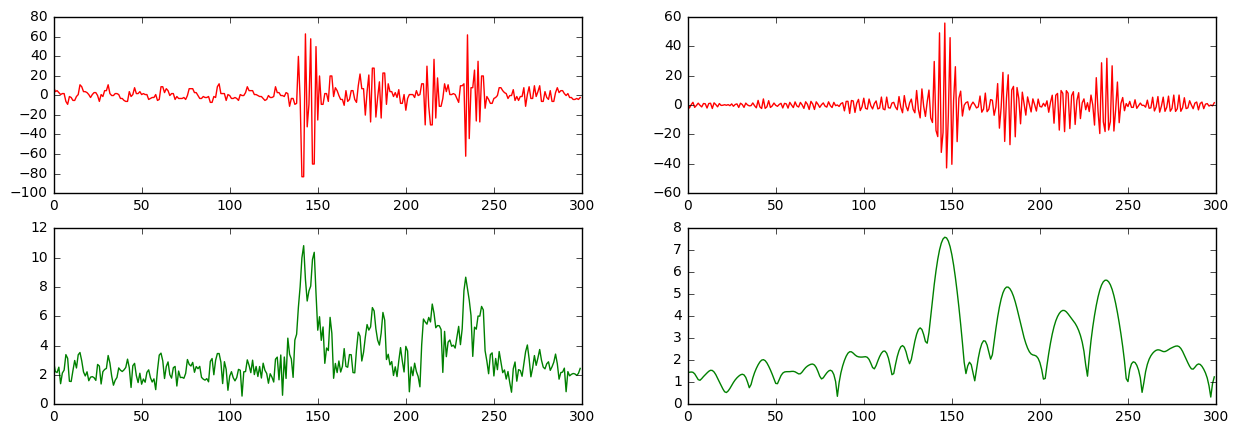

In [4]:
Line,Filtered = ProcessLine(Image[70])
SigHF = np.abs(signal.hilbert(Filtered))
SigH = np.abs(signal.hilbert(Line))

fig, ax = plt.subplots( nrows=2, ncols=2,figsize=(15,5))
ax[0,0].plot(Line[1500:1800],"r")  # plotting 50x 100ns, that's 5µs
ax[1,0].plot(np.sqrt(SigH)[1500:1800],"g" )  # plotting 50x 100ns, that's 5µs
ax[0,1].plot( Filtered[1500:1800],"r")  # plotting 50x 100ns, that's 5µs
ax[1,1].plot(np.sqrt(SigHF)[1500:1800],"g" )  # plotting 50x 100ns, that's 5µs

plt.show()

In [5]:
NbLines, LenLines = np.shape(RawData)

OffSets = []
FFTMap = []
Small = []
Cleaned = []
Hilberted = []
tmp = RawData[0][100:200]

for l in range(NbLines):
    
    Line,Filtered = ProcessLine(RawData[l])
    
    BegLine = Line[100:250]
    Corr = signal.correlate((tmp-260)/40, (BegLine-260)/40, mode='same') 
    ACorr = np.argmax(Corr) #
    OffSets.append((ACorr))
    
    Small.append(RawData[l][0:2200])
    Cleaned.append(np.abs(Filtered))

    Hilberted.append(np.abs(signal.hilbert(Filtered)))

OffMax = max(OffSets) 


## Size

* Without decimation, we have on line the right gabarit. We find that resolution is 14.93 px / mm. That's around 15px / mm. 

* The speed of sound is 1500m/s, so on the image we have 1.332us/mm.
* Acquisition speed is therefore 14.93/1.332 is 11.2Msps.
* The acquarium wall is at 100mm, that should be 1493px

In [87]:
Decimation = 1 
DecSL = 1
NotCentered = 224
NbLinesC = NbLines/Decimation
LenLinesC = LenLines+OffMax+NotCentered

    
def CreateImage(Hilberted):
    NbLines, LenLines = np.shape(Cleaned)
    Image = np.abs(Cleaned)


    Corrected = np.zeros((NbLines, LenLines+OffMax+NotCentered))
    RawImage = np.zeros((NbLines/Decimation, LenLines+OffMax+NotCentered))
    SmallTwo = np.zeros(np.shape(Small))



    for i in range(NbLines):
        for j in range(LenLines-OffMax):
            Corrected[i][j+NotCentered] = Hilberted[i][j-OffSets[i]+OffMax]
            if (j<1500):
                SmallTwo[i][j+NotCentered] = Small[i][j-OffSets[i]+OffMax]
    Corrected[97] = Corrected[96]
    Corrected = Corrected-np.amin(Corrected)
    Corrected = np.sqrt(Corrected)


    for j in range(NbLines/Decimation):
        for k in range(Decimation):
            RawImage [j] += Corrected[Decimation*j+k]

    RawImg = np.zeros((NbLines/Decimation, (LenLines-OffMax)/DecSL))

    for i in range(NbLines/Decimation):
        for j in range((LenLines-OffMax)/DecSL):
            for k in range(DecSL):
                RawImg [i][j] += (RawImage[i][DecSL*j+k])
    return RawImg

In [ ]:
RawImg = CreateImage(Hilberted)
CleanedImage = CreateImage(Cleaned)
np.shape(RawImg)

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(RawImg,cmap=plt.get_cmap('gray'),aspect='auto',)
axarr[1].imshow(CleanedImage,cmap=plt.get_cmap('gray'),aspect='auto',)
plt.show()

In [ ]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]

    SC = np.zeros((LenLinesC,LenLinesC))
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC


In [ ]:
SCH,valuesH,pointsH,LenLinesCH = CreateSC(RawImg)
SCC,valuesC,pointsC,LenLinesCC = CreateSC(CleanedImage)

In [ ]:
f, axarr = plt.subplots(1,2,figsize = (15,7))
axarr[0].imshow(SCH)
axarr[1].imshow(SCC)
plt.show()

In [ ]:
grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
grid_xC, grid_yC = np.mgrid[0:LenLinesCC:1, 0:LenLinesCC:1]

In [ ]:
#grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')
grid_z1C = griddata(pointsC, valuesC, (grid_xC, grid_yC), method='linear')
#grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

In [ ]:
fig = plt.figure()
plt.imshow(grid_z1H,cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
f, axarr = plt.subplots(1,2,figsize = (15,7))
axarr[0].imshow(grid_z1H,cmap=plt.get_cmap('gray'))
axarr[1].imshow(grid_z1C,cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
fig2 = plt.figure(figsize = (7,7)) # create a 5 x 5 figure 
ax3 = fig2.add_subplot(111)
ax3.imshow(grid_z1,cmap=plt.get_cmap('gray'))
ax3.set_title('Deformation corrected (added initial offset)')

plt.show()